In [0]:
import time
import numpy as np
from __future__ import print_function

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Variable
from torchsummary import summary

In [0]:
import torchvision
import torchvision.transforms

In [0]:
import matplotlib.pyplot as plt

#Define image transformations and initialize datasets

In [0]:
mnist_transforms =  torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
mnist_train = torchvision.datasets.MNIST(root = './data', train = True, transform = mnist_transforms, download = True)
mnist_test = torchvision.datasets.MNIST(root = './data', train = False, transform = mnist_transforms, download = True)

#Create multi threaded dataloaders (Multi processor iterators over dataset given batch_size)

In [0]:
trainloader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True, num_workers = 2)
testloader = torch.utils.data.DataLoader(mnist_test, batch_size =64, shuffle = True, num_workers = 2)

#Classifier

In [0]:
class Classifier(nn.Module):
    """Convnet Classifier"""
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv = nn.Sequential(
            # Layer 1
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=2),
            #nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=2),
            #nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1),
            #nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 4
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1),
            #nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 4
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1),
            #nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        )
        # Logistic Regression
        self.clf = nn.Linear(256, 10)

    def forward(self, x):
        return self.clf(self.conv(x).squeeze())

In [0]:
clf = Classifier()
if  torch.cuda.is_available():
    clf = clf.cuda()
optimizer = torch.optim.Adam(clf.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Count number of parameters:


In [0]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [0]:
count_parameters(clf)

394890

In [0]:
from torchsummary import summary
summary(clf, (1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 30, 30]             160
           Dropout-2           [-1, 16, 30, 30]               0
              ReLU-3           [-1, 16, 30, 30]               0
         MaxPool2d-4           [-1, 16, 15, 15]               0
            Conv2d-5           [-1, 32, 17, 17]           4,640
           Dropout-6           [-1, 32, 17, 17]               0
              ReLU-7           [-1, 32, 17, 17]               0
         MaxPool2d-8             [-1, 32, 8, 8]               0
            Conv2d-9             [-1, 64, 8, 8]          18,496
          Dropout-10             [-1, 64, 8, 8]               0
             ReLU-11             [-1, 64, 8, 8]               0
        MaxPool2d-12             [-1, 64, 4, 4]               0
           Conv2d-13            [-1, 128, 4, 4]          73,856
          Dropout-14            [-1, 12

In [0]:
ls_train = []
err_train = []
err_val = []
ls_val = []

for epoch in range(10):
    losses_train = []    
    total_train = 0
    correct_train =0
    

    # Train
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        if torch.cuda.is_available():
            inputs, targets = inputs.cuda(), targets.cuda()

        optimizer.zero_grad()
        inputs, targets = Variable(inputs), Variable(targets)
        outputs = clf(inputs)
        loss_train = criterion(outputs, targets)
        loss_train.backward()
        optimizer.step()
        _, predicted_train = torch.max(outputs.data, 1)
        total_train += targets.size(0)
        correct_train += predicted_train.eq(targets.data).cpu().sum()
        losses_train.append(loss_train.data)

    print('Epoch : %d  Train Acc : %.3f Loss : %.3f ' % (epoch,100.0*correct_train.item()/total_train, torch.mean(torch.stack(losses_train))))
    ls_train.append(np.mean(torch.stack(losses_train).cpu().numpy()))
    err_train.append(1.0 - correct_train.item()/total_train)
    
    # Evaluate
    losses_val = []
    clf.eval()
    total = 0
    correct = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        if torch.cuda.is_available():
            inputs, targets = inputs.cuda(), targets.cuda()

        inputs, targets = Variable(inputs, volatile=True), Variable(targets, volatile=True)
        outputs = clf(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
        loss_val = criterion(outputs, targets)
        losses_val.append(loss_val.data)
        

    print('Epoch : %d Test Acc : %.3f Test loss : %.3f' % (epoch, 100.0*correct.item()/total, torch.mean(torch.stack(losses_val)) ))
    ls_val.append(np.mean(torch.stack(losses_val).cpu().numpy()))
    err_val.append(1.0 - correct.item()/total)
    print('--------------------------------------------------------------')

Epoch : 0  Train Acc : 60.507 Loss : 1.130 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Epoch : 0 Test Acc : 92.040 Test loss : 1.528
--------------------------------------------------------------
Epoch : 1  Train Acc : 92.558 Loss : 0.347 
Epoch : 1 Test Acc : 95.320 Test loss : 0.160
--------------------------------------------------------------
Epoch : 2  Train Acc : 95.718 Loss : 0.143 
Epoch : 2 Test Acc : 95.600 Test loss : 0.136
--------------------------------------------------------------
Epoch : 3  Train Acc : 96.753 Loss : 0.105 
Epoch : 3 Test Acc : 97.380 Test loss : 0.082
--------------------------------------------------------------
Epoch : 4  Train Acc : 97.358 Loss : 0.085 
Epoch : 4 Test Acc : 97.860 Test loss : 0.065
--------------------------------------------------------------
Epoch : 5  Train Acc : 97.665 Loss : 0.073 
Epoch : 5 Test Acc : 97.970 Test loss : 0.058
--------------------------------------------------------------
Epoch : 6  Train Acc : 98.045 Loss : 0.062 
Epoch : 6 Test Acc : 98.410 Test loss : 0.046
------------------------------------

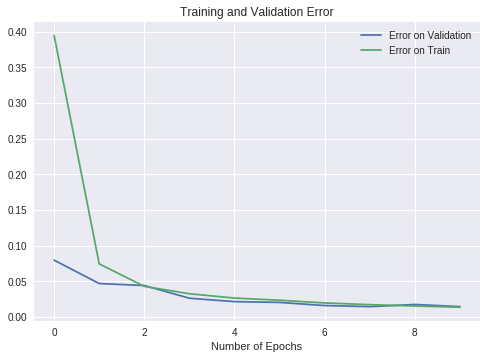

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pylab 

plt.title('Training and Validation Error')
plt.xlabel('Number of Epochs')
pylab.plot(err_val , label = 'Error on Validation')
pylab.plot(err_train , label = 'Error on Train')
pylab.legend(loc='upper right')

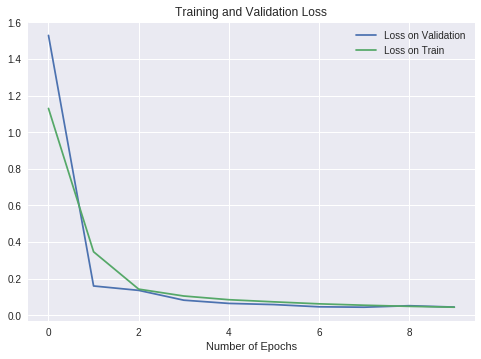

In [0]:
plt.title('Training and Validation Loss')
plt.xlabel('Number of Epochs')
pylab.plot(ls_val , label = 'Loss on Validation')
pylab.plot(ls_train , label = 'Loss on Train')
pylab.legend(loc='upper right')